In [1]:
# Import libraries 
import matplotlib.pyplot as plt
import pandas as pd 
import ta 

from matplotlib import cycler

# facecolor_theme = '#222222' # for origamid theme 

facecolor_theme = '#0d1117' 

colors = cycler('color', 
                ['#669FEE', '#66EE91', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor = facecolor_theme)
plt.rc('axes', facecolor = facecolor_theme, edgecolor = 'none',
       axisbelow = True, grid = False, prop_cycle = colors,
       labelcolor = 'white')
plt.rc('xtick', color = 'white')
plt.rc('ytick', direction = 'out', color = 'white')
plt.rc('legend', facecolor = facecolor_theme, edgecolor = facecolor_theme)
plt.rc('text', color = 'white')
plt.rc('figure', facecolor = facecolor_theme)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from binance import Client
from dotenv import load_dotenv
import os 

# Chargez les variables d'environnement à partir du fichier .env
load_dotenv()

# Accédez à vos clés d'API à l'aide de variables d'environnement
API_KEY = os.getenv("BINANCE_API_KEY")
SECRET_KEY = os.getenv("BINANCE_API_SECRET")

client = Client(API_KEY, SECRET_KEY) 

In [5]:
def import_historical_data(symbol, interval, limit):
    klines  = client.get_historical_klines(symbol, interval, limit)

    klines = [[x[0], float(x[1]), float(x[2]), float(x[3]),
              float(x[4]), float(x[5])] for x in klines]
    klines = pd.DataFrame(klines, columns =['Date', 'Open',
                                           'High', 'Low', 
                                            'Close', 'Volume'])
    klines['Date'] = pd.to_datetime(klines['Date'], unit = 'ms')
    klines = klines.set_index('Date')
    
    return klines

In [6]:
def feature_engineering(df):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["Close"].pct_change(1)

    # Create the SMAs
    df_copy["SMA 15"] = df_copy[["Close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["Close"]].rolling(60).mean().shift(1)
    
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # Create the RSI
    RSI = ta.momentum.RSIIndicator(df_copy["Close"], window= 14, fillna = False)
    df_copy["RSI"] = RSI.rsi().shift(1)
    
    return df_copy.dropna()

In [13]:
# Parameters 
symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_1DAY  # Période d'une journée
limit = '1 year ago UTC'

# Use defined functions 
klines = import_historical_data(symbol, interval, limit)
df_copy = feature_engineering(df=klines)

# First lines 
df_copy.head()

,Open,High,Low,Close,Volume,returns,SMA 15,SMA 60,MSD 10,MSD 30,RSI
Date,,,,,,,,,,,
2022-11-16,16900.57,17015.92,16378.61,16662.76,261493.40809,-0.014071,18706.089333,19319.980667,0.066483,0.041914,37.475665
2022-11-17,16661.61,16751.00,16410.74,16692.56,228038.97873,0.001788,18451.365333,19262.466333,0.066515,0.041810,36.294720
2022-11-18,16692.56,17011.00,16546.04,16700.45,214224.18184,0.000473,18220.746667,19217.072667,0.066877,0.041804,36.564484
2022-11-19,16699.43,16822.41,16553.53,16700.68,104963.15558,0.000014,17986.922000,19169.796500,0.060676,0.041793,36.640984
2022-11-20,16700.68,16753.33,16180.00,16280.23,154842.13478,-0.025176,17690.399333,19133.557833,0.038843,0.041798,36.643383


<AxesSubplot:xlabel='Date'>

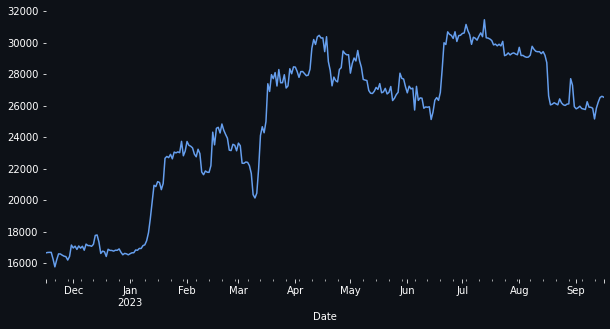

In [14]:
df_copy['Close'].plot(figsize=(10,5))

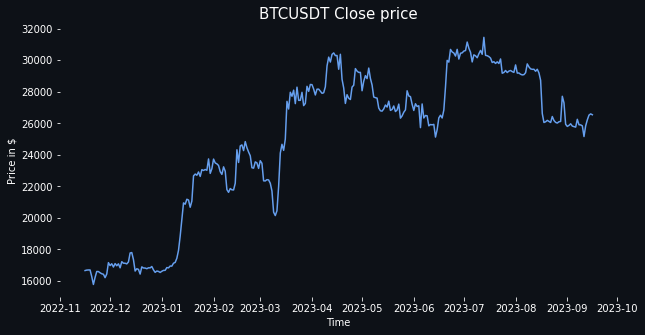

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(df_copy['Close'])
plt.title('BTCUSDT Close price', fontsize=15)
plt.ylabel('Price in $')
plt.xlabel('Time')
plt.show(); 

<AxesSubplot:xlabel='Date'>

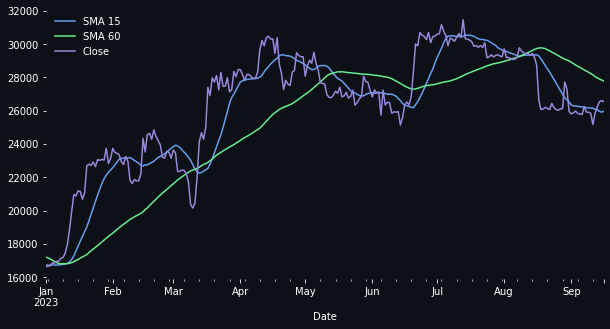

In [16]:
df_copy[["SMA 15", "SMA 60", "Close"]].loc['2023'].plot(figsize=(10,5))

<AxesSubplot:xlabel='Date'>

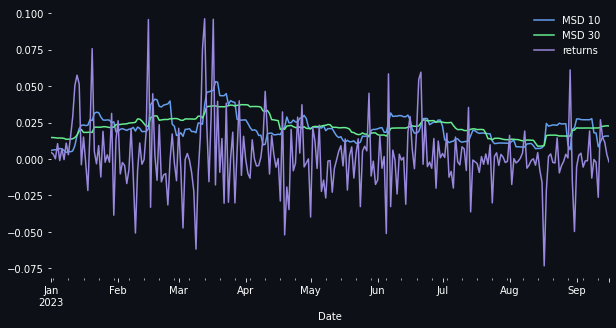

In [17]:
# Plotting MSD
df_copy[["MSD 10", "MSD 30", "returns"]].loc["2023"].plot(figsize=(10,5))

<AxesSubplot:xlabel='Date'>

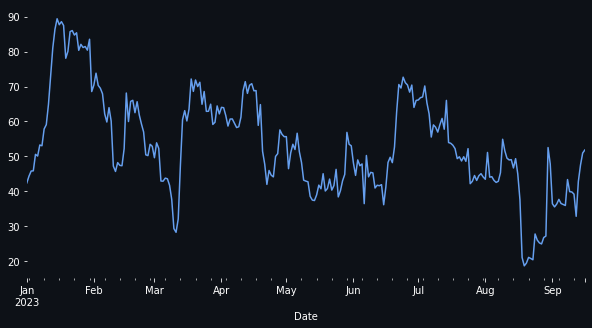

In [18]:
df_copy["RSI"].loc['2023'].plot(figsize=(10,5))